# Mass Balance, Glacier Flow, and Response to a Changing Climate

In class, we discussed the mass balance of glaciers and its relationship with ice flow. In this notebook, we will use OGGM to simulate some of these concepts. Then, we will look at how surface mass balance gradients on glacier impact their response to a chnaging climate. Finally, you will write some of your own code to explore how long it takes a glacier to respond to a change in climate and what that means that sea level rise.

First, we need to install OGGM and import the relevant classes.

In [ ]:
!pip install oggm
!pip install git+https://github.com/OGGM/oggm-edu

In [ ]:
from oggm_edu import MassBalance, GlacierBed, Glacier, GlacierCollection
from matplotlib import pyplot as plt
import numpy as np

## Part 1: The Concept of Steady State

**Part 1a (4 pts):** What does it mean for a glacier to be in steady state, or in equilibrium with it's climate? Use both mathematics and descriptions of the physical state of the glacier to explain this concept.

Start by building a simple glacier domain. Our glacier domain starts at an elevation of 3400 m and ends at an elevation of 1500m. The glacier has a width of 400 m. We set the ELA elevation to 3000 m and define a mass balance gradient (change in mass balance as a function of elevation) to be 4 mm/m. Then we build our glacier object with these properties.

In [ ]:
# Bed
bed = GlacierBed(top=3400, bottom=1500, width=400)
# Mass balance
mass_balance = MassBalance(ela=3000, gradient=4)
# Glacier
glacier = Glacier(bed=bed, mass_balance=mass_balance)

OGGM provides a simple function to progress our glacier until it reaches a steady state.

In [ ]:
glacier.progress_to_equilibrium()
glacier.plot()

Now, let's plot the glacier's mass balance as a function of distance along the centerline in this equilibrium state.

In [ ]:
# We can directly access the annual mass balance of the glacier at every point
# on the surface
mb = glacier.mass_balance.get_annual_mb(glacier.current_state.surface_h)
# Multiply by the widths (converted to meters) and resolution to get
# the grid point mass balance
mb = mb * glacier.bed.widths * glacier.bed.map_dx *\
        glacier.current_state.dx_meter
# Get the glacier thickness at every point on the flowline
thick = glacier.current_state.thick;

# Create a plot of annual mass balance at every point where the glacier thickness
# is greater than zero
fig, ax = plt.subplots()
ax.plot(glacier.bed.distance_along_glacier[glacier.current_state.thick>0],mb[glacier.current_state.thick>0])
ax.set_xlabel('Distance along glacier [km]')
ax.set_ylabel('Mass balance ($m^3s^{-1}$)');

**Part 1b:** Answer the following questions.

(1) (1 pt) What is the approximate location (distance along flowline) of the ELA in steady state?

(2) (3 pts) Given what you know about the relationship between mass balance and ice flux, what do you expect a plot of ice ice flux as a function of flowline distance to look like?  

**Part 1c (6 pts):** Write a function to calculate the ice flux as a function of distance along the glacier centerline and plot your results. Make sure to label the axes with the correct units! The answer the conceptual question below:

(1) Give a physical explanation for the shape of the ice flux function. How would this plot look different if the glacier had not yet reached a steady state?

## Part 2: Changing the mass balance gradient (MBG)  

In this section of the notebook, we will explore the impact that mass balance gradients have on the glacier equilibrium state. The MBG is defined as the change of the mass balance with altitude [¹](#References). It depends strongly on the climate at the glacier [²](#References).

Let's take a look at the effects of the MBG by creating a few glaciers with different gradients. In the intro notebook our glacier had a gradient of 4 mm/m so lets add a glacier with a weaker gradient and one with a stronger gradient.

We will again make use of the `GlacierCollection` to quickly progress and visualise the glaciers.

In [ ]:
collection = GlacierCollection()
glacier.reset()
# Fill the collection. This time we change the attributes on creation.
collection.fill(glacier, n=3, attributes_to_change=
                {'gradient':[0.3, 4, 15]}
               )

# Progress collection to the same year.
collection.progress_to_equilibrium()
collection.plot()

We can also directly access and plot the mass balance of each of the glaciers in our collection as a function of elevation.

In [ ]:
collection.plot_mass_balance()

A stronger mass balance gradient (flatter line in plot above) implies a larger change of the mass balance with altitude.
We can see this in the plot above: The annual mass balance hardly changes with altitude for the glacier with the weakest mass balance gradient (blue) while there is a considerable difference between the top and bottom annual mass balance for the glacier with the strongest mass balance gradient (green).

**Part 2a (2 pts):** Answer the following question.

(1) How do the equilibrium states of the glaciers differ? Which glacier reached its steady state first? Explain why.

Hint: note that you can use the command `collection` to print out the statistics (area, length, volume, etc) or each glacier.




## Response time
The glacier response time is the period of time a glacier needs to adjust its geometry to changes in mass balance caused by climate change and reach a new equilibrium state.
There are a some different definitions for its calculation, OGGM-Edu use the definition from Oerlemans (see formula below) [⁵](#References).

A OGGM-Edu glacier has an attribute `.response_time` which is calculated based on difference between the last two equilibrium states in the glacier history.
So far we've only showed you how to progress a glacier to equilibrium, but not how to leave it and reach a second one.
This will be the first step to getting the response time of a glacier.

We use the glacier from the start of the notebook.

In [ ]:
# Check the state, everything should be zero/nan here.
glacier

First we progress the glacier to equilibrium

In [ ]:
glacier.progress_to_equilibrium()
glacier.plot()

 We can access the stored equilibrium states of a glacier

In [ ]:
glacier.eq_states

Now we want to set up a climate change scenario for the glacier.
This is easily done with the `.add_temperature_bias` method.
This method takes a desired temperature bias ($+/-$) and a duration, which specifies how long it will take for the glacier to reach the climate state.
For instance, if we set the bias to 1. and the duration to 50, it will take 50 years for the climate to become 1 degree warmer.

When a glacier has a climate change scenario the `progress_` methods will internally work a little bit differently, but this is not anything you will notice.

Since we are purely interested in the response of the glacier, we create a climate change scenario with the duration of 1 year.

In [ ]:
# Add a climate change scenario
glacier.add_temperature_bias(bias=1., duration=1)

**Part 2b (2 pts):** Answer the following question.

(1) How will the position of the ELA change when we raise the temperature and why?

In [ ]:
# We can then progress the glacier to equilibrium again
glacier.progress_to_equilibrium()
glacier.plot()

The next step is to calculate the response times for our glaciers. One could think that it is as simple as looking at the years above and do a simple subtraction. However this is not the case! In reality the rate at which a glacier changes is ever decreasing and  a complete equilibrium state is never really achieved. Because of this the response time is considered the time it has taken the glacier to complete most of the adjustment, more specifically all but a factor of $1/e$.  

For numerical models like our glaciers it is common to use the [volume response time](https://www.tandfonline.com/doi/pdf/10.1080/00040851.1997.12003238?needAccess=true), from Oerlemans [⁵](#References):

$$
\tau = t \left(V=V_2 - \frac{V_2 - V_1}{e}\right)
$$

where $V_1$ and $V_2$ corresponds to the glacier volume at the initial and new equilibrium state respectively.

Luckily this is done by our glacier object, so we can just take look at the `.response_time` attribute

In [ ]:
glacier.response_time

Now that we have introduced the concept of response time we can apply it and see how the different mass balance gradients affect the response time.
For this we need a new collection.

In [ ]:
# Bed
bed = GlacierBed(top=3400, bottom=1500, width=400)
# Mass balance
mass_balance = MassBalance(ela=3000, gradient=4)
# Glacier
glacier = Glacier(bed=bed, mass_balance=mass_balance)

collection = GlacierCollection()
# Fill the collection. This time we change the attributes on creation.
collection.fill(glacier, n=3, attributes_to_change=
                {'gradient':[1, 4, 15]}
               )

collection.progress_to_equilibrium()

We then have to set up a climate change scenario for the glaciers in the collection

In [ ]:
# Same scenario for all the glaciers.
collection.glaciers[0].add_temperature_bias(bias=1., duration=1)
collection.glaciers[1].add_temperature_bias(bias=1., duration=1)
collection.glaciers[2].add_temperature_bias(bias=1., duration=1)

# Progress to equilibrium again
collection.progress_to_equilibrium()
collection.plot_history()

We can also look at the state history for one of the glaciers

In [ ]:
# Plots the glacier outline for the equilibrium states.
collection.glaciers[0].plot_state_history(eq_states=True)

**Part 2c:** Answer the following questions.   

(1) (4 pts) Which glacier adjusts most quickly to the changing climate? Why do you think this might be?   

## Part 3: Committed Sea Level Rise ##

In the experiment above, we applied a very rapid change in temperature to see how our glaciers would respond. This time, let's try something closer to the real world. We will simulate the response of an idealized glacier similar to Lovenbreen Glacier in Svalbard, Norway. Our goal is to understand how the timing of sea level contributions from Lovenbreen is related to the rate of Arctic warming.   

**Part 3a (4 pts):** Define a model glacier using the mass balance gradient and ELA measured for Lovenbreen through the 1970s (Hagen & Liestol, 1990).  

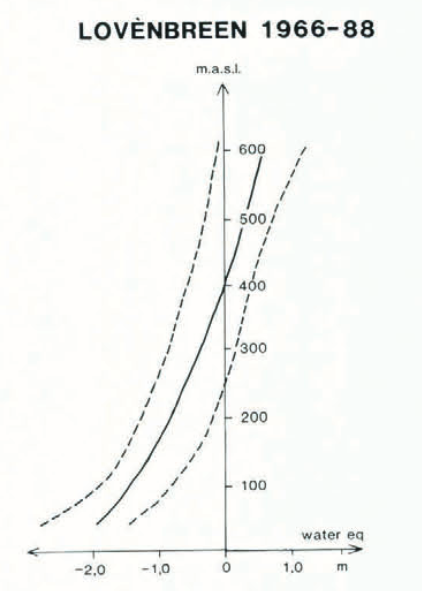

You can assume a linear bed slope of 8.9 degres and an average glacier width of 830 m.

Observations suggest that, since 1980, the Arctic has been warming at a rate of approximately 0.75 C per decade due to Arctic amplification (Rantanen et al., 2022). Suppose that Lovenbreen was in steady state in 1980 (and therefore represented by our equilibrium simulation). Then suppose that tomorrow, we can magically cut global emissions to a level where no more warming occurs (i.e., we stay at 2023 temperatures).   

**Part 3b (11 pts):** Write a function to apply an appropriate temperature bias to our model of Lovenbreen to account for the last 43 years of warming, and then run the model until the glacier achieves a new equilibrium state. Plot the history of glacier length, volume, and area. Then answer the following questions:   

(1) When does the glacier finally reach a new equilibrium state? How is this related to year when we stop increasing the temperature?   

(2) How much volume does the glacier lose after the temperature stops increasing?

(3) If 361.8 $km^3$ of water are required to raise global sea levels by 1 mm, how much will Lovenbreen contribute to sea level rise even after we stop raising the temperature?     

Hint: you can use `glacier.plot_history(show_bias=True)` to include the history of the temperature anomaly in your plot.

Now imagine that instead, tomorrow morning we wake up and someone has discovered a way to reverse warming and bring global temperatures back down to the average 1980 temperature by 2066.  

**Part 3c (13 pts):** Write a function to simulate this whole scenario (starting from 1980) and run the glacier until it reaches a new equilibrium state. Plot the glacier history along with the temperature bias time series. Then answer the questions below:   

(1) When does mass loss from Lovenbreen end? How does this compare to the time period of abnormal climate forcing?   

(2) How does the glacier's final equilibrium state compare to its initial equilibrium state? How long does it take to get back to equilibrium?  

(3) Glaciologists sometimes talk about the concept of "committed sea level rise" or the long-term mass loss from an ice sheet in response to past perturbations that will occur even if greenhouse gas emissions are reduced or stopped. Based on what you learned from this notebook, should we be more concerned about committed sea level rise from cold polar glaciers/ice caps or from warmer mountain glaciers? Why?

In [ ]:
#Run to export to pdf for submission
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

# Mount your google drive to access the notebook directly
from google.colab import drive
drive.mount('/content/drive')

# Make sure this is set to the location of your notebook in your Google Drive
!cp "/content/drive/MyDrive/Colab Notebooks/PS1_MassBalance_Solutions.ipynb" ./

# Change the name of the export file to [NetID]_PS2_BalanceVelocities.ipynb
!jupyter nbconvert --to PDF "PS1_MassBalance_Solutions.ipynb"

## References

¹ Rasmussen, L. A., & Andreassen, L. M. (2005). Seasonal mass-balance gradients in Norway. *Journal of Glaciology*, 51(175), 601-606.

² Oerlemans, J., & Fortuin, J. P. F. (1992). Sensitivity of glaciers and small ice caps to greenhouse warming. *Science, 258(5079)*, 115-117.

³ Oerlemans, J. (2001). *Glaciers and climate change*. CRC Press.

⁴ Encyclopedia of snow, ice and glaciers, V.P. Singh, P. Singh, and U.K. Haritashya, Editors. 2011, Springer: Dordrecht, The Netherlands. p. 245-256.

⁵ Oerlemans, J. (1997). Climate sensitivity of Franz Josef Glacier, New Zealand, as revealed by numerical modeling. *Arctic and Alpine Research*, 29(2), 233-239.

⁶ Anderson, B., Lawson, W., & Owens, I. (2008). Response of Franz Josef Glacier Ka Roimata o Hine Hukatere to climate change. Global and Planetary Change, 63(1), 23-30.

⁷ Cuffey, K.M. & Paterson, W.S.B. *The Physics of Glaciers, 4th edition*, 704 (Academic Press, 2010).


## What's next?

[Back to the table of contents](../welcome.ipynb)